In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import matplotlib
import matplotlib.pyplot as plt
from keras.metrics import mean_absolute_error
from keras.metrics import mean_absolute_percentage_error
from keras.metrics import mean_squared_error


# Libraries for displying the data. 
from IPython.core.display import HTML 
from ipywidgets import interact
from IPython.display import display
import seaborn as sns
%matplotlib inline

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Dataset
downloaded = drive.CreateFile({'id':"12f9gd7u5hGDwWEZgOd-O9iMkM6lE9vF-"})   # replace the id with id of file you want to access
downloaded.GetContentFile('stock_prices_sample.csv')        # replace the file name with your file
#Dataset
downloaded = drive.CreateFile({'id':"1jJapq3dnv8iyMHtxJSp-hRJl8E1rCrUu"})   # replace the id with id of file you want to access
downloaded.GetContentFile('data.csv')        # replace the file name with your file

In [0]:
stock_prices = pd.read_csv('stock_prices_sample.csv')

In [0]:
stock_prices['DATE'] = pd.to_datetime(stock_prices["DATE"])
stock_prices['date'] = stock_prices['DATE']
stock_prices = stock_prices.sort_values(by="DATE")
stock_prices.set_index("DATE", inplace = True) 
stock_prices['Year']=stock_prices.index.year
stock_prices = stock_prices[stock_prices.Year != 2013]

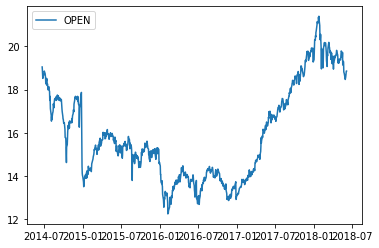

In [0]:
sns.lineplot(data=stock_prices['OPEN'], label="OPEN") 

In [0]:
def lag_features(df , N , col , col_index):
  "adds lag features of the given columnb for previous N days"
  series = df[col]
  for i in range(N):
    shifted_rows = np.zeros(len(df))
    shifted_rows[:] = np.nan
    array_index = i+1
    for j in range(len(df)-(i+1)):
      shifted_rows[array_index] = df.iloc[j,col_index]
      array_index = array_index + 1 
      df[col+'_lag_'+str(i+1)] = shifted_rows
  return df

In [0]:
stock_prices.columns

Index(['TICKER', 'FIGI', 'TYPE', 'FREQUENCY', 'OPEN', 'HIGH', 'LOW', 'CLOSE',
       'VOLUME', 'ADJ_OPEN', 'ADJ_HIGH', 'ADJ_LOW', 'ADJ_CLOSE', 'ADJ_VOLUME',
       'ADJ_FACTOR', 'EX_DIVIDEND', 'SPLIT_RATIO', 'date', 'Year'],
      dtype='object')

In [0]:
stock_prices = stock_prices[['OPEN', 'HIGH', 'LOW', 'CLOSE','VOLUME' , 'date' , 'Year']]

In [0]:
stock_prices_w_lag = lag_features(stock_prices,7,'OPEN',0)

In [0]:
stock_prices_w_lag. dropna( inplace = True)

**Deep Neural Network**

In [0]:
import keras
from keras.layers import Dense
from keras.models import Sequential 
from keras.activations import relu
from keras.activations import softmax
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

In [0]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=[7]))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss="mse", optimizer=SGD(lr=1e-6, momentum=0.9))

In [0]:
trainX = np.array(stock_prices_w_lag[['OPEN_lag_1' , 'OPEN_lag_2' , 'OPEN_lag_3' , 'OPEN_lag_4' , 'OPEN_lag_5' , 'OPEN_lag_6' ,'OPEN_lag_7']])
trainY = np.array(stock_prices_w_lag['OPEN'])

In [0]:
testX = trainX[:100]
trainX = trainX[100:]
testY = trainY[:100]
trainY = trainY[100:]


In [0]:
trainX.shape

(889, 7)

In [0]:
early_stopping_monitor = EarlyStopping(patience=3)
model.fit(trainX , trainY, validation_split=0.2, epochs=100, callbacks=[early_stopping_monitor] , verbose=1)

Train on 711 samples, validate on 178 samples
Epoch 1/100
711/711 [==============================] - 0s 44us/step - loss: 0.2264 - val_loss: 0.2489
Epoch 2/100
711/711 [==============================] - 0s 37us/step - loss: 0.2264 - val_loss: 0.2489
Epoch 3/100
711/711 [==============================] - 0s 37us/step - loss: 0.2264 - val_loss: 0.2488
Epoch 4/100
711/711 [==============================] - 0s 34us/step - loss: 0.2263 - val_loss: 0.2488
Epoch 5/100
711/711 [==============================] - 0s 35us/step - loss: 0.2264 - val_loss: 0.2488
Epoch 6/100
711/711 [==============================] - 0s 36us/step - loss: 0.2263 - val_loss: 0.2487
Epoch 7/100
711/711 [==============================] - 0s 33us/step - loss: 0.2263 - val_loss: 0.2487
Epoch 8/100
711/711 [==============================] - 0s 35us/step - loss: 0.2264 - val_loss: 0.2487
Epoch 9/100
711/711 [==============================] - 0s 33us/step - loss: 0.2261 - val_loss: 0.2487
Epoch 10/100
711/711 [==============

In [0]:
pred = model.predict(testX)

In [0]:
print(keras.metrics.mean_squared_error(testY, pred).numpy().mean())
print(keras.metrics.mean_absolute_error(testY, pred).numpy().mean())
print(keras.metrics.mean_absolute_percentage_error(testY, pred).numpy().mean())

1.5677544
0.9993111
5.890814


In [0]:
 pred = pred.reshape(100)

In [0]:
pred.shape

(100,)

In [0]:
d = {'pred': pred, 'testY': testY}
df = pd.DataFrame(data=d)

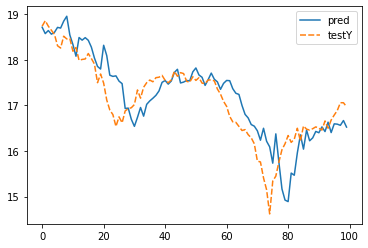

In [0]:
sns.lineplot(data=df) 

**Single** **Neural** **Network**

In [0]:
import keras
from keras.layers import Dense
from keras.models import Sequential 
from keras.activations import relu
from keras.activations import softmax
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

In [0]:
model = Sequential()
model.add(Dense(1 , input_shape=[7]))
model.compile(loss="mse", optimizer=SGD(lr=1e-6, momentum=0.9))

In [0]:
early_stopping_monitor = EarlyStopping(patience=3)
model.fit(trainX , trainY, validation_split=0.2, epochs=100, callbacks=[early_stopping_monitor] , verbose=1)

Train on 711 samples, validate on 178 samples
Epoch 1/100
711/711 [==============================] - 0s 45us/step - loss: 0.2324 - val_loss: 0.2553
Epoch 2/100
711/711 [==============================] - 0s 35us/step - loss: 0.2323 - val_loss: 0.2552
Epoch 3/100
711/711 [==============================] - 0s 35us/step - loss: 0.2321 - val_loss: 0.2552
Epoch 4/100
711/711 [==============================] - 0s 36us/step - loss: 0.2322 - val_loss: 0.2551
Epoch 5/100
711/711 [==============================] - 0s 35us/step - loss: 0.2321 - val_loss: 0.2551
Epoch 6/100
711/711 [==============================] - 0s 35us/step - loss: 0.2320 - val_loss: 0.2550
Epoch 7/100
711/711 [==============================] - 0s 35us/step - loss: 0.2321 - val_loss: 0.2550
Epoch 8/100
711/711 [==============================] - 0s 34us/step - loss: 0.2321 - val_loss: 0.2550
Epoch 9/100
711/711 [==============================] - 0s 36us/step - loss: 0.2320 - val_loss: 0.2549
Epoch 10/100
711/711 [==============

In [0]:
pred = model.predict(testX)

In [0]:
print(keras.metrics.mean_squared_error(testY, pred).numpy().mean())
print(keras.metrics.mean_absolute_error(testY, pred).numpy().mean())
print(keras.metrics.mean_absolute_percentage_error(testY, pred).numpy().mean())

1.5709566
1.0001767
5.8953567


In [0]:
 pred = pred.reshape(100)

In [0]:
pred.shape

(100,)

In [0]:
d = {'pred': pred, 'testY': testY}
df = pd.DataFrame(data=d)

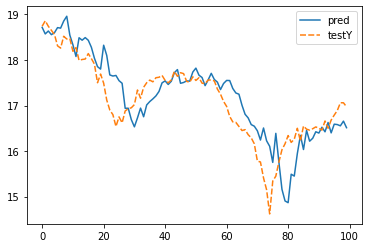

In [0]:
sns.lineplot(data=df) 